TP DE MACHINE LEARNING !!!

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('WineQT.csv')

<AxesSubplot:>

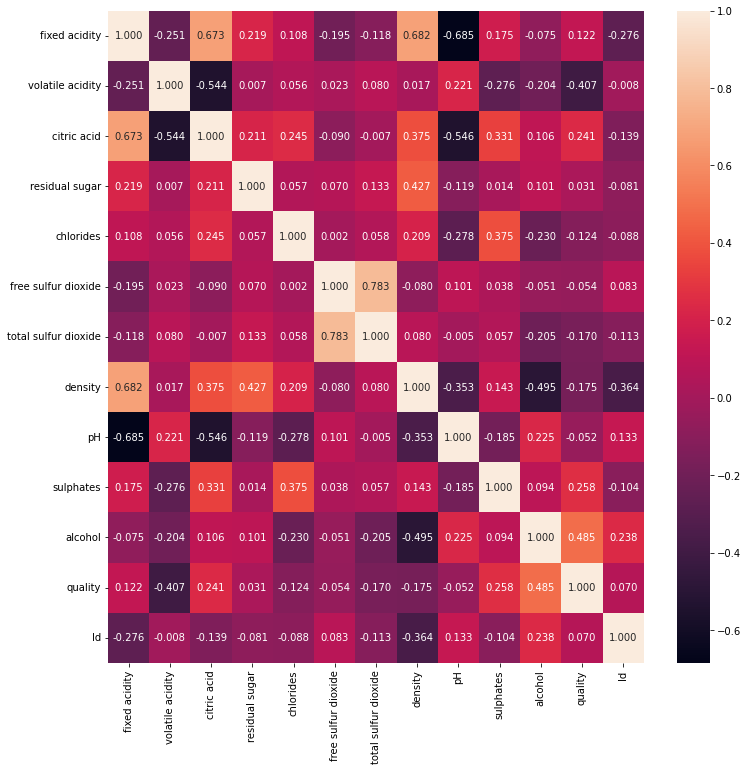

In [10]:
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.3f')

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(40, 30))
for n in range(12):
    i = n % 3
    j = n % 4
    ax[i, j].hist(df.iloc[:, n], bins='auto')
    ax[i, j].set_title(df.columns[n])

VOIR LES VARIABLES : ON SE CONCENTRE SUR ['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']

[[0.7  9.4  0.56 0.  ]]
[5 5 5 ... 5 6 5]
1143
1143


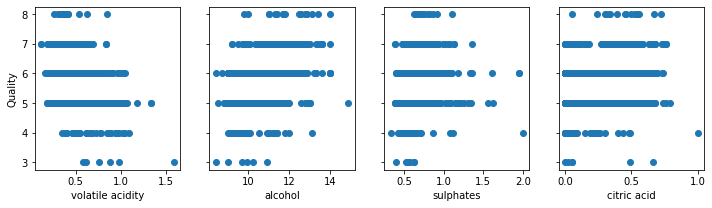

In [68]:
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)
print(X_train[:1])
print(y_train)
print(len(X_train))
print(len(y_train))
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_train[:,i]],[y_train])
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Quality")
plt.show()


NORMALISATION

In [50]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

# normalize the original features



In [61]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [[ 0.53133858 10.4421114   0.65770779  0.26836395]], 
X_sigma = [[0.1795546  1.0817221  0.17032416 0.19659979]]
Peak to Peak range by column in Raw        X:[[1.46 6.5  1.67 1.  ]]
Peak to Peak range by column in Normalized X:[[8.13123157 6.00893702 9.80483344 5.08647531]]


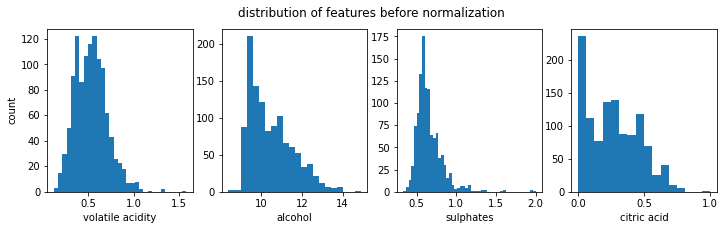

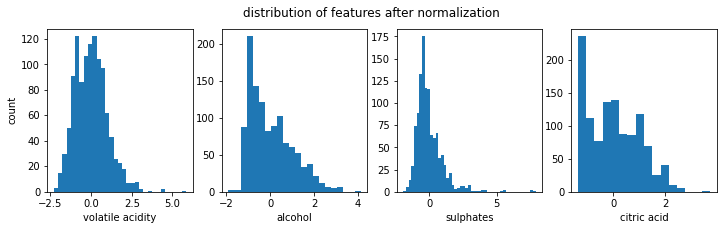

In [62]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    ax[i].hist(X_train[:,i],bins='auto')
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count")
fig.suptitle("distribution of features before normalization")
plt.show()
fig,ax=plt.subplots(1,4,figsize=(12,3))

for i in range(len(ax)):
    ax[i].hist(X_norm[:,i],bins='auto')
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count"); 
fig.suptitle("distribution of features after normalization")

plt.show()

DESCENTE DE GRADIENT : 

In [87]:
import copy
import math


def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        # if i% math.ceil(num_iters / 10) == 0:
            
           # print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, np.squeeze(J_history) #return final w,b and J history for graphing

Huperparametre alpha

w_init shape: (4,), b_init type: <class 'int'>
b,w found by gradient descent: [[2.82781127e-05]],[1.47306797e-05 2.97394731e-04 1.87755001e-05 7.77948711e-06] 
prediction: [[0.00284461]], target value: 5
prediction: [[0.00296848]], target value: 5
prediction: [[0.00296646]], target value: 5
prediction: [[0.00296212]], target value: 6
prediction: [[0.00284461]], target value: 5
prediction: [[0.00284403]], target value: 5
prediction: [[0.00284173]], target value: 5
prediction: [[0.00302062]], target value: 7
prediction: [[0.00287293]], target value: 7
prediction: [[0.00278361]], target value: 5
prediction: [[0.00299131]], target value: 5
prediction: [[0.0027751]], target value: 5
prediction: [[0.00317349]], target value: 7
prediction: [[0.00279327]], target value: 6
prediction: [[0.00293337]], target value: 5
prediction: [[0.00287858]], target value: 5
prediction: [[0.00284181]], target value: 5
prediction: [[0.00293182]], target value: 6
prediction: [[0.00281155]], target value: 5
predi

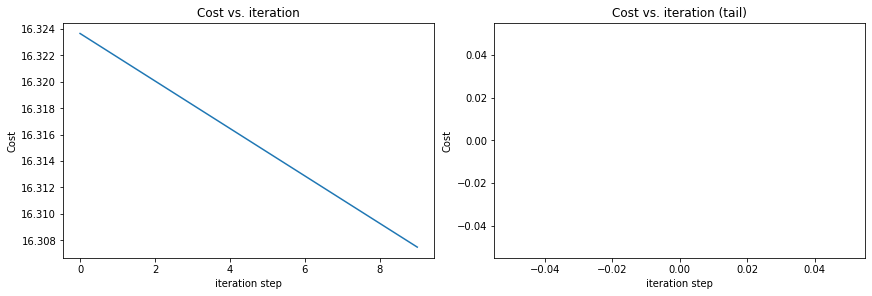

In [89]:
# initialize parameters
b_init = 0
w_init = np.array([ 0,0,0,0])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 200
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,alpha, iterations)
print(f"b,w found by gradient descent: {b_final},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final}, target value: {y_train[i]}")

print(J_hist)
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()